# AMV in FOCI-OpenIFS

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress
from scipy.stats import t

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41245 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:44433 Dashboard: http://127.0.0.1:41245/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

In [9]:
#exp_list = ['focioifs-merge14']
#exp_list = ['FOCI_GJK001','FOCI_NJK007','FOCI_NJK007_cont3']
#time_list = [slice('1850-01-01','3000-01-01'), slice('1850-01-01','2300-01-01'),slice('2300-01-01','3000-01-01')]

#exp_list = ['FOCI_GJK001','foci-cpl-06']
#time_list = [slice('1850-01-01','3000-01-01'),slice('1850-01-01','3150-01-01')]

#exp_list = ['foci-test-05','foci-test-07']
#time_list = [slice('1850-01-01','1960-01-01'),slice('1850-01-01','1960-01-01')]

# Old continuation that did not work
#exp_list = ['FOCI_GJK001','FOCI_GJK001_cont']
#time_list = [slice('1850-01-01','3000-01-01'),slice('3000-01-01','3200-01-01')]

# New FOCI-OpenIFS 2.1.1
exp_list = ['FOCI_GJK029']
time_list = [slice('1850-01-01','2850-01-01')]
version = [1]

In [10]:
# OpenIFS surface
ds_sfc_all = []
for exp,time,v in zip(exp_list,time_list,version):
    if v == 0:
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir2,exp)
    else:
        sfc = '%s/%s/outdata/oifs/ym/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK029/outdata/oifs/ym/*1y*regular_sfc.nc


In [11]:
ds_sfc_full = xr.concat(ds_sfc_all, compat='equals', dim='time')
ds_sfc_full

<xarray.Dataset>
Dimensions:            (time: 730, bnds: 2, lon: 192, lat: 96)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 2579-07-01 06:00:00
  * lon                (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * lat                (lat) float32 -89.06 -87.19 -85.31 ... 85.31 87.19 89.06
Dimensions without coordinates: bnds
Data variables: (12/45)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    sstk               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ci                 (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    es                 (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    tclw               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    tciw               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ...                 ...
    swvl1              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl2              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl3              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl4              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    sro                (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ssro               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         ECE3_1m_18500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2023-Feb-19 13:41:02 GMT
    uuid:         3b3166db-6c1a-4d78-ba3e-27bee07b9dfe
    history:      Mon Feb 20 11:30:37 2023: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [12]:
def wgtm(data):
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    wgt = data.weighted(weights)
    mean = wgt.mean(('lon','lat'))
    return mean

def amv(sst):
    lon1 = 290
    lon2 = 360
    lat1 = 40
    lat2 = 70
    amv = wgtm( sst.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)) )
    return amv

In [13]:
amv_all = []

if 1:
    
    # Compute AMV index
    amv_raw = amv(ds_sfc_full['sstk']).compute()
    
    # Annual
    amv_y = amv_raw.groupby('time.year').mean('time')
    amv_index = amv_y - amv_y.mean('year')
    
    # 10-year running mean
    amv_run = amv_index.rolling(year=11,center=True).mean()
    
    amv_all.append(amv_run)

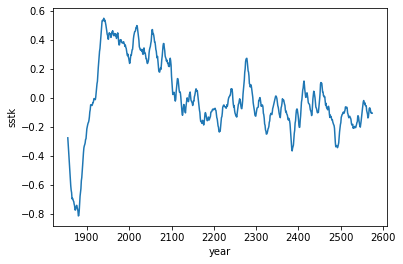

In [15]:
fig1, ax1 = plt.subplots(1,1)

for i, (amv, exp) in enumerate( zip(amv_all, exp_list) ):
    
    #ax1.plot(amv, label=exp)
    amv.plot(ax=ax1)
    
fig1.savefig('plots/amv_full.pdf',format='pdf')

## Regression of AMV index on surface variables

In [33]:
def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

def correlation(x, y, dim='time'):
    cov = ((x - x.mean(dim=dim))* (y - y.mean(dim=dim))).mean(dim=dim)
    corr = cov / x.std(dim=dim) / y.std(dim=dim)
    return corr

def significance(r,n):
    #t = r / np.sqrt(1 - r**2) * np.sqrt((n - 2).where(n > 2))
    #p_values = t.copy()
    #p_values.values = (2 
    #                   * sns.distributions.stats.t.sf(
    #                   np.abs(t.where(n>2)),
    #                   df=n.where(n>2)-2))
    tstats = r * np.sqrt(n-2) / np.sqrt(1-r**2)
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=r.dims, coords=r.coords)
    return pval

In [54]:
# Select only last 400 years
years = slice(2200,2600)

In [55]:
# AMV and SAT
# 10-year low pass filter for SAT
sat_10 = ds_sfc_full['2t'].groupby('time.year').mean('time').rolling(year=11,center=True).mean()
r_amv_sat = correlation(amv.sel(year=years), sat_10.sel(year=years), dim='year').compute()
n = amv.shape[0]
p = significance(r_amv_sat, n).compute()

In [56]:
# AMV and precip
# 10-year low pass filter for SAT
tp_10 = ds_sfc_full['tp'].groupby('time.year').mean('time').rolling(year=11,center=True).mean()
r_amv_tp = correlation(amv.sel(year=years), tp_10.sel(year=years), dim='year').compute()
n = amv.shape[0]
p_tp = significance(r_amv_tp, n).compute()

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


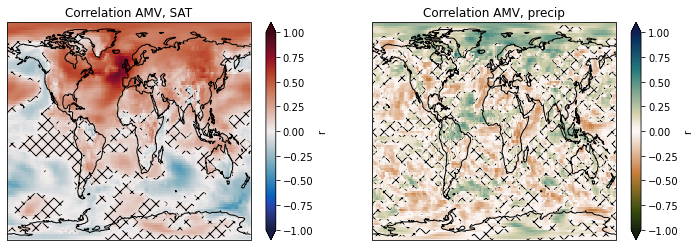

In [58]:
fig, ax1 = plt.subplots(1,2, figsize=(12,4),
                       subplot_kw={'projection':ccrs.PlateCarree()})

cb_kw = {'extend':'both', 'label':'r'}
r_amv_sat.plot(ax=ax1[0], cbar_kwargs=cb_kw, 
               vmin=-1, vmax=1,
               cmap=cmocean.cm.balance,
               transform=ccrs.PlateCarree(),
               rasterized=True)
p.plot.contourf(ax=ax1[0],levels=(0, 0.05,1.), transform=ccrs.PlateCarree(),
                colors='none', hatches=(None, 'xx'),
                add_colorbar=False)

r_amv_tp.plot(ax=ax1[1],transform=ccrs.PlateCarree(), 
              vmin=-1, vmax=1,
              cmap=cmocean.cm.tarn,
              cbar_kwargs=cb_kw,
              rasterized=True)
p_tp.plot.contourf(ax=ax1[1],levels=(0, 0.05,1.), transform=ccrs.PlateCarree(),
                    colors='none', hatches=(None, 'xx'),
                    add_colorbar=False)

for ax in ax1:
    ax.coastlines()
    ax.set_aspect('auto')

ax1[0].set_title('Correlation AMV, SAT')
ax1[1].set_title('Correlation AMV, precip')
fig.tight_layout()
fig.savefig('plots/amv_correlations.pdf',format='pdf',dpi=150)